In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import string
import requests
import io
import nltk
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [3]:
sess = tf.Session()

batch_size = 200
max_features = 1000

In [4]:
save_file_name = 'temp_spam_data.csv'
if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_namem, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    # And write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

In [5]:
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

# Relabel 'spam' as 1, 'ham' as 0
target = [1. if x=='spam' else 0. for x in target]

# Normalize text
# Lower case
texts = [x.lower() for x in texts]

# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snuist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# Create TF-IDF of texts
tfidf = TfidfVectorizer(tokenizer=tokenizer, 
                        stop_words='english',
                       max_features=max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)

In [8]:
sparse_tfidf_texts.shape

(5574, 1000)

In [9]:
train_indices = np.random.choice(sparse_tfidf_texts.shape[0],
                                round(0.8*sparse_tfidf_texts.shape[0]),
                                 replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) - set(train_indices)))

texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

In [10]:
# Creat Variables
A = tf.Variable(tf.random_normal(shape=[max_features,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[None, max_features],dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Declare logistic model(sigmoid in loss function)
model_output = tf.add(tf.matmul(x_data, A), b)

In [11]:
# Declare loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, 
                                                              labels=y_target))
# Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [12]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_opt.minimize(loss)

# Initialize Vaariables
init = tf.global_variables_initializer()
sess.run(init)

In [16]:
texts_test.shape

(1115, 1000)

In [17]:
texts_test.todense().shape

(1115, 1000)

In [19]:
target_test.shape

(1115,)

In [18]:
np.transpose([target_test]).shape

(1115, 1)

In [27]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], # generating random index at the size of train data
                                  size=batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100 == 0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, 
                                  feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
        
        test_acc_temp = sess.run(accuracy, 
                                 feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
        
    if (i+1)%500 == 0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print("Generation # {}. Train Loss(Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})".format(*acc_and_loss))

Generation # 500. Train Loss(Test Loss): 0.40 (0.42). Train Acc (Test Acc): 0.87 (0.87)
Generation # 1000. Train Loss(Test Loss): 0.46 (0.42). Train Acc (Test Acc): 0.85 (0.87)
Generation # 1500. Train Loss(Test Loss): 0.47 (0.42). Train Acc (Test Acc): 0.85 (0.87)
Generation # 2000. Train Loss(Test Loss): 0.48 (0.42). Train Acc (Test Acc): 0.84 (0.87)
Generation # 2500. Train Loss(Test Loss): 0.41 (0.42). Train Acc (Test Acc): 0.88 (0.87)
Generation # 3000. Train Loss(Test Loss): 0.48 (0.42). Train Acc (Test Acc): 0.84 (0.87)
Generation # 3500. Train Loss(Test Loss): 0.44 (0.42). Train Acc (Test Acc): 0.86 (0.87)
Generation # 4000. Train Loss(Test Loss): 0.45 (0.42). Train Acc (Test Acc): 0.84 (0.87)
Generation # 4500. Train Loss(Test Loss): 0.50 (0.42). Train Acc (Test Acc): 0.84 (0.87)
Generation # 5000. Train Loss(Test Loss): 0.47 (0.42). Train Acc (Test Acc): 0.84 (0.87)
Generation # 5500. Train Loss(Test Loss): 0.52 (0.42). Train Acc (Test Acc): 0.83 (0.87)
Generation # 6000. Tra

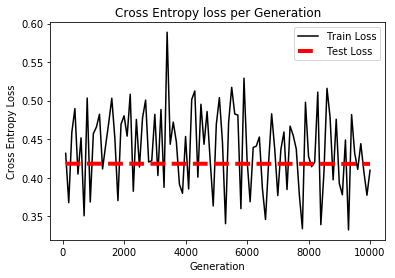

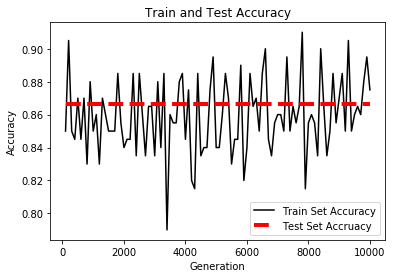

In [31]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label="Train Loss")
plt.plot(i_data, test_loss, 'r--', label="Test Loss", linewidth=4)
plt.title('Cross Entropy loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accruacy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
